In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from supergrad.scgraph.graph import SCGraph
from supergrad.helper import Spectrum

# preload a random key, let the random number generator generate the same random number
key = jax.random.PRNGKey(1)

In [2]:
class Params:
    def __init__(self, ec, ej, ng=0.0):
        self.ec = ec
        self.ej = ej
        # self.shared_param_mark = shared_param_mark
        # remove shared_param_mark because it only works for the back propagation
        self.ng = ng # The highest bound level sensitive to ng

def create_transmon(params):
    ec = params.ec
    ej = params.ej
    ng = params.ng

    transmon = {
            "ec": ec,
            "ej": ej,
            "system_type": "transmon",
            'arguments': {
                'ng': ng,
                'num_basis': 62,
                'n_max': 31,
                'phiext': 0.,
            }
        }

    return transmon

class SingleTransmon(SCGraph):
    def __init__(self, transmon_0):
        super().__init__()

        # nodes represent qubits
        self.add_node("q0", **transmon_0)

    def get_energies(self):
        spec_1q = Spectrum(self, truncated_dim=10, share_params=False, unify_coupling=False)
        # disable share_params because it only works for the back propagation
        # disable "unify_coupling" and direct assign the coupling strength by the edge
        params_1q = spec_1q.all_params
        return spec_1q.energy_tensor(params_1q)

In [3]:
# generate an array of ej with a typical value of 12.5 GHz and a Gaussian variation of 500 MHz
ej_mean = 12.5
ej_var = 0.5
ej_array = ej_mean + ej_var * jax.random.normal(key, 1000)

@jax.vmap
def get_spectra(ej):
    tm = create_transmon(Params(250e-3, ej, ng=0.0))
    energy_1q = SingleTransmon(tm).get_energies()
    return energy_1q[1] - energy_1q[0]

freq_array = get_spectra(ej_array)

Text(0.5, 1.0, 'Fit results: mu = 4.74,  std = 0.10')

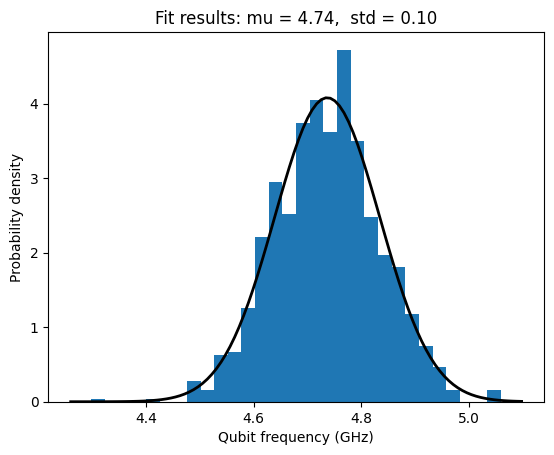

In [4]:
# plot the histogram of ej_array, normalized to the Gaussian envelope
import matplotlib.pyplot as plt
plt.figure()
plt.hist(freq_array, bins=30, density=True)
plt.xlabel('Qubit frequency (GHz)')
plt.ylabel('Probability density')

# fit the histogram with a Gaussian
from scipy.stats import norm
mu, std = norm.fit(freq_array)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)


## Multiple Transmon Qubits in a Chain 

In [5]:
# Construct the graph of multiple transmons
class Params_VariableEJ:
    def __init__(self, ec, ej_array, coupling, ng=0.0):
        self.ec = ec
        self.ej_array = ej_array
        self.coupling = coupling
        self.ng = ng # The highest bound level sensitive to ng

class MultiTransmons_VariableEJ_Chain(SCGraph):
    def __init__(self, params):
        super().__init__()

        # nodes represent qubits
        for i in range(len(params.ej_array)):
            self.add_node(f"q{i}", **create_transmon(Params(params.ec, params.ej_array[i], params.ng)))

        # edges represent two-qubit interactions
        for i in range(len(params.ej_array) - 1):
            self.add_edge(f"q{i}", f"q{i+1}", **{
                'capacitive_coupling': {
                    'strength': params.coupling
                }
            })

    def get_energies(self):
        spec = Spectrum(self)
        # disable "unify_coupling" and direct assign the coupling strength by the edge
        params = spec.all_params
        return spec.energy_tensor(params)


### Example: Two coupled transmon qubits

In [6]:
ec = 300e-3
ej_array = [98.8, 101.2]
coupling = 40e-3
twoQ = MultiTransmons_VariableEJ_Chain(Params_VariableEJ(ec, ej_array, coupling, ng=0.5))
print(twoQ.get_energies())

[[-184.6505333  -169.30848726 -154.50248739 -139.87676531 -125.54400961]
 [-169.62255866 -154.12306492 -139.08716817 -124.75306691 -110.59019329]
 [-154.84464615 -139.56953755 -124.21212415 -109.50216199  -95.74782841]
 [-140.38473708 -125.17183525 -110.12722465  -94.98684489  -80.7468862 ]
 [-126.26263511 -111.06840004  -96.26785822  -81.71179614  -67.01816691]]


### Excitation energy of two coupled transmon qubits

In [7]:
from functools import partial

n_transmons = 2
ej_mean = 12.5
ej_var = 0.5
ej_array = ej_mean + ej_var * jax.random.normal(key, n_transmons)
ec = 250e-3

t_array = jnp.linspace(0, 50e-3, 100)

@partial(jax.vmap, in_axes=(0, None, None))
def get_energies(coupling, ej_array, ec):
    twoQ = MultiTransmons_VariableEJ_Chain(Params_VariableEJ(ec, ej_array, coupling, ng=0.0))
    return twoQ.get_energies()


energy_2q_array = get_energies(t_array, ej_array, ec)

Text(0, 0.5, 'Excitation frequency (GHz)')

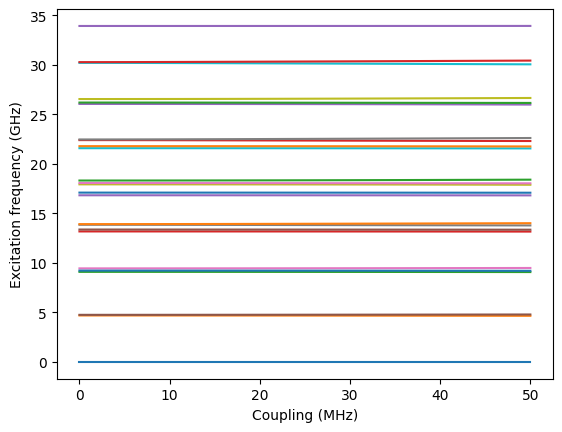

In [8]:
plt.figure()
for i in range(5):
    for j in range(5):
        plt.plot(1e3*t_array, energy_2q_array[:,i,j] - energy_2q_array[:,0,0])
plt.xlabel('Coupling (MHz)')
plt.ylabel('Excitation frequency (GHz)')


Text(0, 0.5, 'Excitation frequency (GHz)')

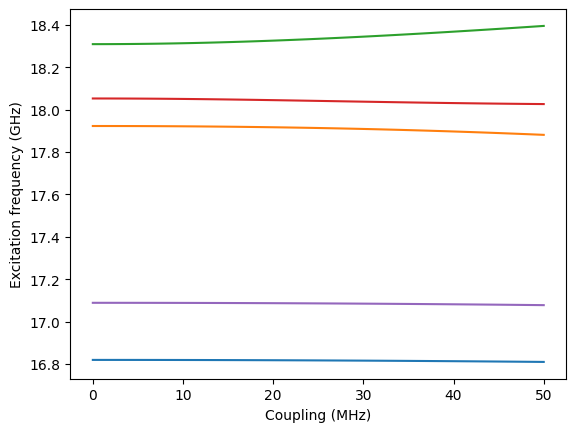

In [9]:
for i in range(5):
    j = 4 - i
    plt.plot(1e3*t_array, energy_2q_array[:,i,j] - energy_2q_array[:,0,0])
plt.xlabel('Coupling (MHz)')
plt.ylabel('Excitation frequency (GHz)')


### Excitation energy of four coupled transmon qubits

In [14]:
n_transmons = 4
ej_mean = 12.5
ej_var = 0.5
ej_array = ej_mean + ej_var * jax.random.normal(key, n_transmons)
ec = 250e-3

t_array = jnp.linspace(0, 50e-3, 100)
energy_4q_array = get_energies(t_array, ej_array, ec)

In [11]:
print(energy_4q_array.shape)

(100, 5, 5, 5, 5)


(8.75, 9.8)

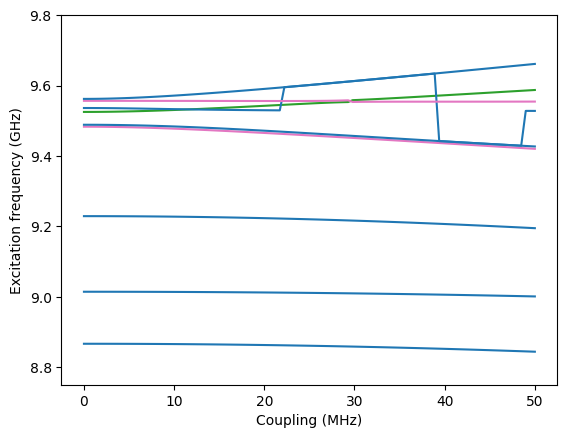

In [15]:
# minus ground state energy
origin_shape = energy_4q_array.shape
spectra_4q = (energy_4q_array.reshape(origin_shape[0], -1) -
              energy_4q_array.reshape(origin_shape[0], -1)[:, 0].reshape(-1, 1))
plt.plot(1e3 * t_array, spectra_4q)
plt.xlabel('Coupling (MHz)')
plt.ylabel('Excitation frequency (GHz)')
plt.ylim(8.75, 9.8)